# AI4Code Pytorch DistilBert Baseline + a 설명

- 
Author 
I used a lot of code from Kaggle's starter notebook here: https://www.kaggle.com/code/ryanholbrook/getting-started-with-ai4code
I replaced their model with a DistilBert model.

- 기존 공개되어있던 Sample code를 BASE로 작성된 코드
    - 모델을 DistilBERT로 변경
- 최종 성능은 0.73정도이지만 다른 샘플코드들 처럼 Package단으로 활용하는것이 아닌, low level로 작성되어 있는 코드
    - 과제 전반적인 이해에 도움이 될 것이라 판단, 해당 스크립트를 선정함
    - 그렇다고 해도 huggingface를 활용하지 않는건 아님, 하여 패키지를 처음 써보는 사람들도 이해할 수 있도록 최대한 자세하게 코드 작성(본인 기준..)
- 모델 IN & OUT 과 해당 대회의 평가 metric인 Kandall-tau metric까지 알아보록 구성되어있음

- P.S. 의식의 흐름대로 작성한 스크립트이다보니.. 작성한 설명을 읽어도 이해가 잘 안될 수 있습니다.. 양해 부탁드립니다 ㅎㅎㅎ

## import packge

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

# 미리 download 받아놓은 distilbert model 경로, multilingual인지는 확인 필요함
BERT_PATH = "../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased"

data_dir = Path('./input/AI4Code')

## Input 데이터 관련 함수 정리

In [2]:
# 사용할 데이터 수, 샘플로 1만건만 활용
NUM_TRAIN = 10000

# json파일을 통해 해당 notebook 파일 불러옴
def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem) # DataFrame에 새 열을 할당하는 메서드. 할당할 새 열이 기존열과 이름이 같을경우 덮어씌워짐
        .rename_axis('cell_id')
    )

# 리스트 내 확장자가 json인 파일 import
paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]

# 읽어온 notebook을 리스트 형태로 저장
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]

# pd.dataframe 형태로 저장 
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel() # 인덱스의 기준값을 변경해줌 
    .sort_index(level='id', sort_remaining=False)
)

df

Train NBs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.67it/s]


cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
00062ab8487156 dcad687f      code  # This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
               a2e1fc80      code                                   test_esrb_df = pd.read_csv("/kaggle/input/video-games-rating-by-esrb/test_esrb.csv")\n
               7d977ee8      code  vidgme_esrb_df = pd.read_csv("/kaggle/input/video-games-rating-by-esrb/Video_games_esrb_rating.csv")\nother_cols = [...
               45a82a59      code           esrb_percentages_df = vidgme_esrb_df.drop(other_cols, axis=1).sum() / len(vidgme_esrb_df)\nesrb_percentages_df
               cbbc326a      code                                                             vidgme_esrb_df.pivot_table(index=["esrb_rating", "console"])
...                           ...                                                                                                                      ...
fffc63ff750064 56aa8da7      code                                                                 \nsubmission.to_csv('house_price_rf.csv', index = False)
               411b85d9  markdown                                                                                                    1. # Data exploration
               e7e67119  markdown                                                                                                   # # Data preprocessing
               8b54cf58  markdown                                                                                            # Post-process for submission
               b3c6bc16  markdown                                                                                                   # Define and fit model

[458950 rows x 2 columns]

In [3]:
# 일반적인 index가 아닌 multi_index 구조
df.index[0:3]

In [3]:
# 샘플데이터(notebook) 확인
# 노트북은 코드와 Markdown 순서가 정렬되어있지 않음(disordered)
nb_id = df.index.unique('id')[3]
print('Notebook:', nb_id)

print("The disordered notebook:")
nb = df.loc[nb_id, :]
display(nb)
print()

Notebook: 002aed65301beb
The disordered notebook:


,cell_type,source
cell_id,,
48716f4c,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
0823d03c,code,import numpy as np \nimport pandas as pd \nimport matplotlib.pyplot as plt
0d2f52d8,code,data = pd.read_csv('/kaggle/input/news-dataset-18920/result_final.csv')
f43790ac,code,data.shape
0c0d4bdb,code,data.head()
...,...,...
8da3ac1d,markdown,## Step 2: Encoding your data\n### There are a number of popular encoding schemes but the main ones are:\n\n* ### On...
3ed6f004,markdown,* ### The method of calculating the user’s likes / dislikes / measures is calculated by taking the cosine of the ang...
404ef4ab,markdown,![1_3Ig7VSgscBzXaYa0Q-UM1w.png](attachment:1_3Ig7VSgscBzXaYa0Q-UM1w.png)


In [4]:
# Train 데이터(notebook)의 order 순서가 적혀있는 데이터(train_orders.csv) import
# 여기서의 id는 notebook 단위
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # cell_id가 텍스트로 붙어있음, 띄어쓰기 단위로 끊어서 리스트화

print(df_orders.shape)
df_orders.head(2)

/tmp/ipykernel_19480/1233448445.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df_orders = pd.read_csv(


(139256,)


id
00001756c60be8    [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136...
00015c83e2717b    [2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c417225b, 51e3cd89, 2600b4eb, 75b65993, cf195f8b, 25699d02, 72b3201a, f2c75...
Name: cell_order, dtype: object

In [12]:
# 예시: 002ba502bdac45 노트북의 cell 수
len(df_orders.loc["002ba502bdac45"])

In [5]:
# 위에서 확인했던 notebook을 train_order.csv를 활용해
# cell 재정렬 후 결과 확인 (실제 복윈되어야 하는 notebook output)

cell_order = df_orders.loc[nb_id]

print("The ordered notebook:")
nb.loc[cell_order, :]

The ordered notebook:


,cell_type,source
cell_id,,
62f7252e,markdown,## How to Build a Content-Based Recommender System For Your Product ??
98a54f4b,markdown,### Presenting users with the most relevant information is an important task for any product to fulfill. To do this ...
856a652e,markdown,![Inner-blog-image.png](attachment:Inner-blog-image.png)
23360c29,markdown,## Recommender systems\n### There are two main data selection methods:\n\n* ### Collaborative-filtering: In collabor...
48716f4c,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
...,...,...
c4810a3d,code,"ds.insert(2,'cluster',clusters)\n\n#ds.insert(0,'id',range(0,ds.shape[0]))"
dee88f34,code,ds.head()
c13bef0e,code,ds['cluster'].value_counts()


In [6]:
# 위 결과처럼
# 정렬되어있지 않는 Train 데이터(notebook)의 cell 순서(rank)를 구하는 함수 설정
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

cell_ranks = get_ranks(cell_order, list(nb.index))
nb.insert(0, 'rank', cell_ranks)

In [7]:
# 전체 Trainset의 rank 구함
df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

df_ranks

rank
id             cell_id      
00062ab8487156 dcad687f    0
               a2e1fc80    1
               7d977ee8    2
               45a82a59    3
               cbbc326a    4
...                      ...
fffc63ff750064 56aa8da7   25
               411b85d9    1
               e7e67119    6
               8b54cf58   22
               b3c6bc16   18

[458950 rows x 1 columns]

In [8]:
# ancestor & parent_id 데이터 가져옴
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df_ancestors.head(2)

,ancestor_id,parent_id
id,,
00001756c60be8,945aea18,NaN
00015c83e2717b,aa2da37e,317b65d12af9df


In [9]:
# train set에 ancestor & parent info merge
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id
0,00062ab8487156,dcad687f,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...,0,de362dd8,NaN
1,00062ab8487156,a2e1fc80,code,"test_esrb_df = pd.read_csv(""/kaggle/input/video-games-rating-by-esrb/test_esrb.csv"")\n",1,de362dd8,NaN
2,00062ab8487156,7d977ee8,code,"vidgme_esrb_df = pd.read_csv(""/kaggle/input/video-games-rating-by-esrb/Video_games_esrb_rating.csv"")\nother_cols = [...",2,de362dd8,NaN
3,00062ab8487156,45a82a59,code,"esrb_percentages_df = vidgme_esrb_df.drop(other_cols, axis=1).sum() / len(vidgme_esrb_df)\nesrb_percentages_df",3,de362dd8,NaN
4,00062ab8487156,cbbc326a,code,"vidgme_esrb_df.pivot_table(index=[""esrb_rating"", ""console""])",4,de362dd8,NaN
...,...,...,...,...,...,...,...
458945,fffc63ff750064,56aa8da7,code,"\nsubmission.to_csv('house_price_rf.csv', index = False)",25,0a1b5b65,NaN
458946,fffc63ff750064,411b85d9,markdown,1. # Data exploration,1,0a1b5b65,NaN
458947,fffc63ff750064,e7e67119,markdown,# # Data preprocessing,6,0a1b5b65,NaN
458948,fffc63ff750064,8b54cf58,markdown,# Post-process for submission,22,0a1b5b65,NaN


In [10]:
# rank / 각 id마다 cell의 개수 
# 해당 값을 학습 시에는 y LABEL로 활용함
#   - Cell 전체를 0~1로 보았을 때, 해당 Cell이 몇%정도에 위치하고 있는지에 대한 값
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")
# df["pct_rank"].hist(bins=10)
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,00062ab8487156,dcad687f,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...,0,de362dd8,NaN,0.0
1,00062ab8487156,a2e1fc80,code,"test_esrb_df = pd.read_csv(""/kaggle/input/video-games-rating-by-esrb/test_esrb.csv"")\n",1,de362dd8,NaN,0.083333
2,00062ab8487156,7d977ee8,code,"vidgme_esrb_df = pd.read_csv(""/kaggle/input/video-games-rating-by-esrb/Video_games_esrb_rating.csv"")\nother_cols = [...",2,de362dd8,NaN,0.166667
3,00062ab8487156,45a82a59,code,"esrb_percentages_df = vidgme_esrb_df.drop(other_cols, axis=1).sum() / len(vidgme_esrb_df)\nesrb_percentages_df",3,de362dd8,NaN,0.25
4,00062ab8487156,cbbc326a,code,"vidgme_esrb_df.pivot_table(index=[""esrb_rating"", ""console""])",4,de362dd8,NaN,0.333333
...,...,...,...,...,...,...,...,...
458945,fffc63ff750064,56aa8da7,code,"\nsubmission.to_csv('house_price_rf.csv', index = False)",25,0a1b5b65,NaN,0.961538
458946,fffc63ff750064,411b85d9,markdown,1. # Data exploration,1,0a1b5b65,NaN,0.038462
458947,fffc63ff750064,e7e67119,markdown,# # Data preprocessing,6,0a1b5b65,NaN,0.230769
458948,fffc63ff750064,8b54cf58,markdown,# Post-process for submission,22,0a1b5b65,NaN,0.846154


## 모델링

- GroupShuffleSplit
    - Shuffle-Group(s)-Out cross-validation iterator(그룹단위로 cross-validation 가능하도록 하는 iterator 인듯)
    
    Provides randomized train/test indices to split data according to a
    third-party provided group. This group information can be used to encode
    arbitrary domain specific stratifications of the samples as integers.

### Train / Valid 분리

In [11]:
from sklearn.model_selection import GroupShuffleSplit

NVALID = 0.1  # size of validation set

splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)
train_ind, val_ind = next(splitter.split(df, groups=df["ancestor_id"]))

train_df = df.loc[train_ind].reset_index(drop=True)
val_df = df.loc[val_ind].reset_index(drop=True)

train_df.shape, val_df.shape

((413503, 8), (45447, 8))

In [12]:
# ancestor_id를 key값 비율 확인
print(df.ancestor_id.nunique(), train_df.ancestor_id.nunique(), val_df.ancestor_id.nunique())
print(train_df.ancestor_id.nunique()/df.ancestor_id.nunique(), val_df.ancestor_id.nunique()/df.ancestor_id.nunique())

9801 8820 981
0.8999081726354453 0.10009182736455463


In [13]:
val_df.head()

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,002d93ddca8c5d,b6afdfdb,code,import numpy as np\nimport matplotlib.pyplot as plt,1,d0cda2e5,NaN,0.02439
1,002d93ddca8c5d,522b1069,code,"C = np.array([[0.022,0.01,-0.001,0.011,0.005],[0.01,0.033,0,0.014,0.01],[-0.001,0,0.019,-0.001,-0.001],[0.011,0.014,...",4,d0cda2e5,NaN,0.097561
2,002d93ddca8c5d,f9a6802d,code,C_invers = np.linalg.inv(C)\nprint(C_invers),5,d0cda2e5,NaN,0.121951
3,002d93ddca8c5d,c215d32e,code,"u = np.array([[1],[1],[1],[1],[1]])\nprint(u)",7,d0cda2e5,NaN,0.170732
4,002d93ddca8c5d,d7b802ab,code,u_T = u.transpose()\nprint(u_T),8,d0cda2e5,NaN,0.195122


### 필요 함수 정의

In [22]:
from bisect import bisect

def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

---------------------
설명을 위해 임시로 작성한 부분, 실제 serving에는 필요 없음
 
 

### 함수 관련 설명

- 실제 함수를 line by line으로 돌려보면서 설명 할 예정
- 그 전에 대회 평가지표인 Kandall tau METRIC 에 대한 이해 필요

- 공식 싸이트 내에 평가지표 설명 <br>
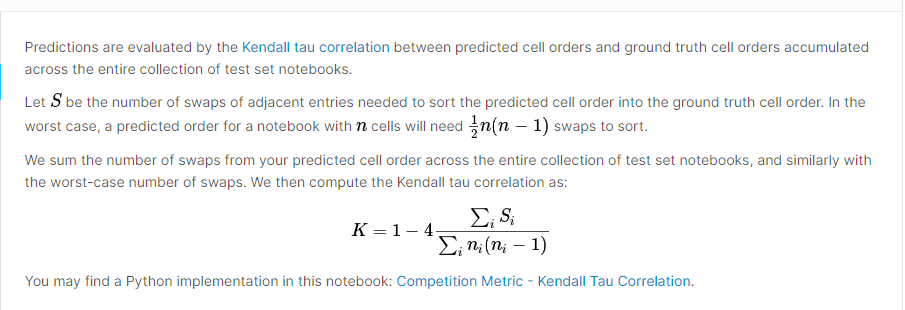

- 예측된 순서를 ground truth 순서로 정렬하는 데 필요한 셀의 스왑 수(= inversion)를 계산, 예측된 셀 순서와 ground truth 셀 순서 간의 Kendall tau 상관 관계를 계산할 수 있음
    - 인덱스의 쌍 i,j는 i<j이지만 A[i]>A[j]일 때 숫자 시퀀스 A 내에서 반전(= inversion)이라고 함.
        - 염: inversion은 시퀀스의 숫자 쌍이 순서가 잘못되었음을 나타냄, 잘못되었으므려 swap 해야한다고 설명한듯...?
- 예측을 올바르게 정렬하는 데 필요한 스왑 수는 실제 순위와 관련된 셀 순위의 반전 수(예측 틀린 스왑 수)와 동일함

#### 위 내용은 직관적으로 이해하기 어려움

- 위 수식에서 각 부분이 나타내는 건수는
    - S(i): 각 row(여기서는 notebook_id)마다 등장한 틀린 조합 개수
    - n(i)/(n(i)-1): 등장하는 모든 스왑 개수
        - 여기서 스왑이란 한 notebook 안에 있는 모든 cell의 조합
            - ex) 전체 cell 4개면 <br>
                스왑의 개수는 총 12개: (1, 2) (1, 3) (1, 4) (2, 3) (2, 4) (3, 4) X 2배( (2, 1) (3, 1) 이런식으로 있을수 있으므로)

#### 설명을 위한 샘플 데이터
(자료가 없으면 설명이 어려울 듯 하여 추가했으나.. 여전히 쉽지않아보임)

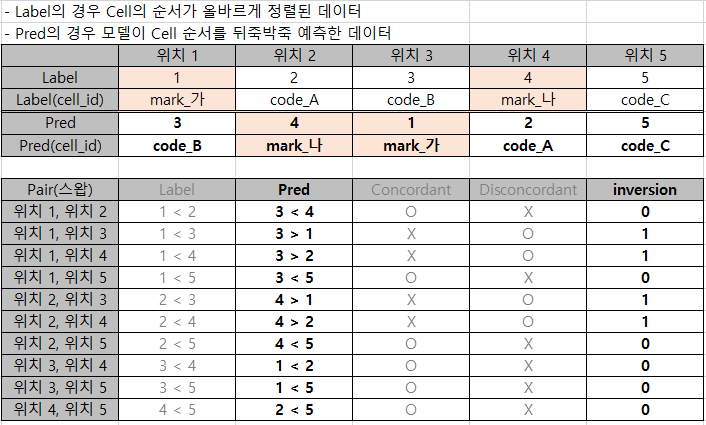

- Label: 실제 정확한 Cell order rank
- Pred: 모델이 예측한 Cell order rank

- 첫번째 수식이 inversion을 계산하는 직관적인 함수
    - But 조합 하나하나 다 계산을 하기때문에 엄청 느림..
- 실제로는 두번째 수식을 활용
    - 이해 X, 개념은 이해했으니 일단 그냥 사용하기로 ㅎㅎ..

In [ ]:
def count_inversions_slowly(ranks):
    inversions = 0
    size = len(ranks)
    for i in range(size):
        for j in range(i+1, size):
            if ranks[i] > ranks[j]:
                inversions += 1
    return inversions

def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions

-  실제 

In [31]:
# dummy 데이터 생성, code, markdown이 섞이지 않은 그대로 불러옴
display(val_df.head())
y_dummy = val_df.groupby('id')['cell_id'].apply(list)
y_dummy.head()

In [48]:
_predictions = y_dummy                       # Dummy data
_ground_truth = df_orders.loc[y_dummy.index] # 실제 Label값, y_dummy.index = 'id'임

print(f'ground truth 리스트:\n {_ground_truth[:2]}','\n\n', f'pred 리스트:\n {_predictions[:2]}\n\n\n')

# 실제 
total_inversions = 0
total_2max = 0  # twice the maximum possible inversions across all instances(?)

for gt, pred in zip(_ground_truth, _predictions):   
    ranks = [gt.index(x) for x in pred]  # 예측값을 gt에 넣어 gt의 index값을 가져옴
    
    total_inversions += count_inversions(ranks)
    n = len(gt)
    total_2max += n * (n - 1)

kd_t_result = (1 - 4 * total_inversions / total_2max)
kd_t_result

임시 작성 내용 끝!

--------------------- 

In [49]:
y_dummy = val_df.groupby('id')['cell_id'].apply(list)
kendall_tau(df_orders.loc[y_dummy.index], y_dummy)

In [53]:
# Markdown cell 개수도 상당히 많음
val_df["cell_type"].value_counts()

### 학습데이터 생성

In [54]:
# train & Valid 중 Markdown 부분만 분리해서 생성
train_df_mark = train_df[train_df["cell_type"] == "markdown"].reset_index(drop=True)
val_df_mark = val_df[val_df["cell_type"] == "markdown"].reset_index(drop=True)

In [55]:
train_df_mark

In [62]:
# 실제 학습간에 Metric으로 활용하는 값 설정 & 테스트
# Markdown Cell의 위치 %(pct_rank)를 기반으로 예측함
# 아래 내용은 그냥 metric이 동작하나 확인해보기 위한 테스트
from sklearn.metrics import mean_squared_error

mean_squared_error(val_df_mark["pct_rank"]
                   , np.ones(val_df_mark.shape[0]) * train_df_mark["pct_rank"].mean() # valid set 길이만큼의 1 값 X pct_rank의 평균
                  )

### 모델링 진행

In [66]:
# 필요 패키지 import & model archi 생성
from tqdm import tqdm
import sys, os
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

MAX_LEN = 128

class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_PATH)
        self.top = nn.Linear(768, 1)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = self.top(x[:, 0, :])
        return x

In [67]:
# MarkdownDataset 생성
# 기존 작성자가 MarkdownDataset으로 네이밍 한 이유는, markdown code만 활용해서 그런 것 같음
from torch.utils.data import DataLoader, Dataset

class MarkdownDataset(Dataset):
    
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row.source,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]
    
train_ds = MarkdownDataset(train_df_mark, max_len=MAX_LEN)
val_ds = MarkdownDataset(val_df_mark, max_len=MAX_LEN)

# 결과 예시
val_ds[0] # ids, mask, torch.FloatTensor([row.pct_rank]) 의 구조

In [100]:
# Train 데이터 예시
BERT_PATH = "../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased"
_tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

tmp_train = train_ds[23]
tmp_valid = val_ds[0]

# 결과 print
print(f'----- Train Example -----')
print(f'- Input_id:\n {tmp_train[0]}')
print(f"- Input_id Decode:\n {_tokenizer.decode(tmp_train[0]).replace('[PAD]', '')}") # PADDING값은 너무 길어져서 삭제함
print(f"- pct_rank:\n {tmp_train[2]}") # PADDING값은 너무 길어져서 삭제함

print(f'\n\n\n----- Valid Example -----')
print(f'- Input_id:\n {tmp_valid[0]}')
print(f"- Input_id Decode:\n {_tokenizer.decode(tmp_valid[0]).replace('[PAD]', '')}") # PADDING값은 너무 길어져서 삭제함
print(f"- pct_rank:\n {tmp_valid[2]}") # PADDING값은 너무 길어져서 삭제함

In [101]:
# lr scheduler & optimizer 생성(기본적이긴 하지만 이런거까지 low level로 구현해놓으거 보면 쓸만한 코드인 것 같긴함)
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer

In [105]:
# batch size & worker 수 설정
BS = 32
NW = 2 # 기존 8, 본인 kaggle 노트북에서는 2밖에 안되서 값 수정

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

In [108]:
train_ds[0]

In [112]:
# Train & Valid 함수 정의
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()


def validate(model, val_loader):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            pred = model(inputs[0], inputs[1])

            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
    
    return np.concatenate(labels), np.concatenate(preds)

def train(model, train_loader, val_loader, epochs):
    np.random.seed(0)
    
    optimizer = get_optimizer(model)

    criterion = torch.nn.MSELoss()
    
    for e in range(epochs):   
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        lr = adjust_lr(optimizer, e)
        
        loss_list = []
        preds = []
        labels = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            optimizer.zero_grad()
            pred = model(inputs[0], inputs[1])

            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.detach().cpu().item())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            
            avg_loss = np.round(np.mean(loss_list), 4)

            tbar.set_description(f"Epoch {e+1} Loss: {avg_loss} lr: {lr}")
            
        y_val, y_pred = validate(model, val_loader)
            
        print("Validation MSE:", np.round(mean_squared_error(y_val, y_pred), 4))
        print()
    return model, y_pred

model = MarkdownModel()
model = model.cuda()
model, y_pred = train(model, train_loader, val_loader, epochs=1)

In [115]:
# id & cell_type별로 gropby 후 최종 pred값 생성
val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred

In [116]:
# pred값으로 값 sort 후 kandall tau 값 확인
y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
kendall_tau(df_orders.loc[y_dummy.index], y_dummy)

### Submission 데이터 생성

In [117]:
# submission 데이터 import

paths_test = list((data_dir / 'test').glob('*.json'))
notebooks_test = [
    read_notebook(path) for path in tqdm(paths_test, desc='Test NBs')
]
test_df = (
    pd.concat(notebooks_test)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
).reset_index()

In [118]:
# submission 데이터 전처리
test_df["rank"] = test_df.groupby(["id", "cell_type"]).cumcount()
test_df["pred"] = test_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)

In [119]:
# submission 데이터 format 변경
test_df["pct_rank"] = 0 # 임시 percent 값 생성
test_ds = MarkdownDataset(test_df[test_df["cell_type"] == "markdown"].reset_index(drop=True), max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

len(test_ds), test_ds[0]

In [120]:
# 실제 Model에 Inference 후 예측값 생성
_, y_test = validate(model, test_loader)

In [121]:
# Submission 데이터에 결과값 append
test_df.loc[test_df["cell_type"] == "markdown", "pred"] = y_test

In [122]:
# Submission 데이터 생성
sub_df = test_df.sort_values("pred").groupby("id")["cell_id"].apply(lambda x: " ".join(x)).reset_index()
sub_df.rename(columns={"cell_id": "cell_order"}, inplace=True)
sub_df.head()

In [123]:
# submission 데이터 저장
sub_df.to_csv("submission.csv", index=False)